## Task : Implementing RNN and LSTM with forward and backward prop in numpy 

In [4]:
import numpy as np
from rnn_utils import *

In [5]:
%config Completer.use_jedi = False

### Forward propagation  for RNN

This is a RNN Cell representation : 

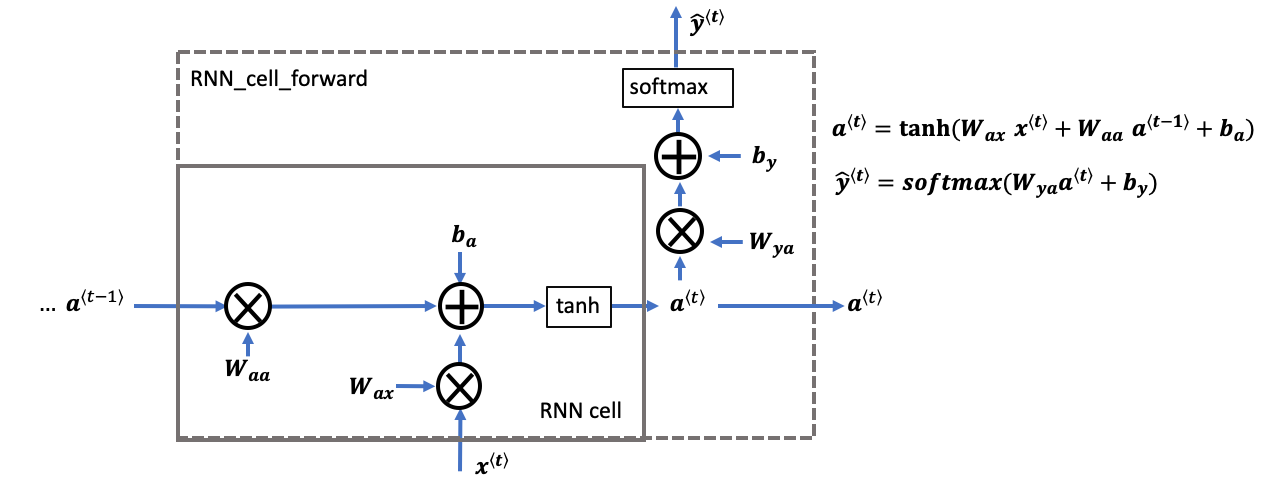

Here RNN_cell_forward is the forward prop we will implement where we will compute the hidden state activation $a^{<t>}$

Then we will use the hidden state activation to compute the prediction y at a given 

In [10]:
def rnn_cell_forward(xt,a_prev,params): 
    
    '''
    Single forward step of a RNN Cell
    
    xt -- your input data at timestep "t", numpy array of shape (n_x, m).
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        ba --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    
    '''
    
    # Retrieving parameters
    Wax = params['Wax']
    Waa = params['Waa']
    Wya = params['Wya']
    ba = params['ba']
    by = params['by']
    
    a_next = np.tanh(np.dot(Waa,a_prev) + np.dot(Wax,xt) + ba)
    yt_pred = softmax(np.dot(Wya,a_next) + by)
    
    cache = (a_next,a_prev,xt,params)
    
    return a_next,yt_pred,cache

#### Forward pass for RNN 

The RNN is multiple RNN cells stacked together

Now we will implemement the forward pass for RNN by running multiple rnn_cell_forward calls for total time stamps of input given

In [14]:
def rnn_forward(x,a0,params): 
    
    """ 
    Forward pass implementation for RNN (the big boy)
    
    x -- Input data with (n_x,m,T_x)
    a0 -- Initial hidden state of shape (n_a,m)
    params -- the good old dictionary
    """
    
    caches = []
    
    # Retrieving stuff
    n_x,m,T_x = x.shape
    n_y, n_a = params['Wya'].shape
    
    # initializing the a and y and a_next
    a = np.zeros([n_a,m,T_x])
    y_pred = np.zeros([n_y,m,T_x])
    a_next = a0
    
    # all time stamps of input
    for t in range(T_x):
        # Updating the next_hidden state
        a_next,yt_pred,cache = rnn_cell_forward(x[:,:,t],a_next,params)
        
        # saving value of a_next to a<t>
        a[:,:,t] = a_next
        
        # saving value of y prediction
        y_pred[:,:,t] = yt_pred
        
        # appending cache to caches
        caches.append(cache)
    
    caches = (caches,x) # for backprop help
    
    return a,y_pred,caches


### Backward Propagation time

Although inthe many deep learning frameworks, they already provide us the luxury of not bothering with backward propagation still for the sake of building from scratch we will see backprop

This image easily depicts the steps for backward pass in a RNN-cell

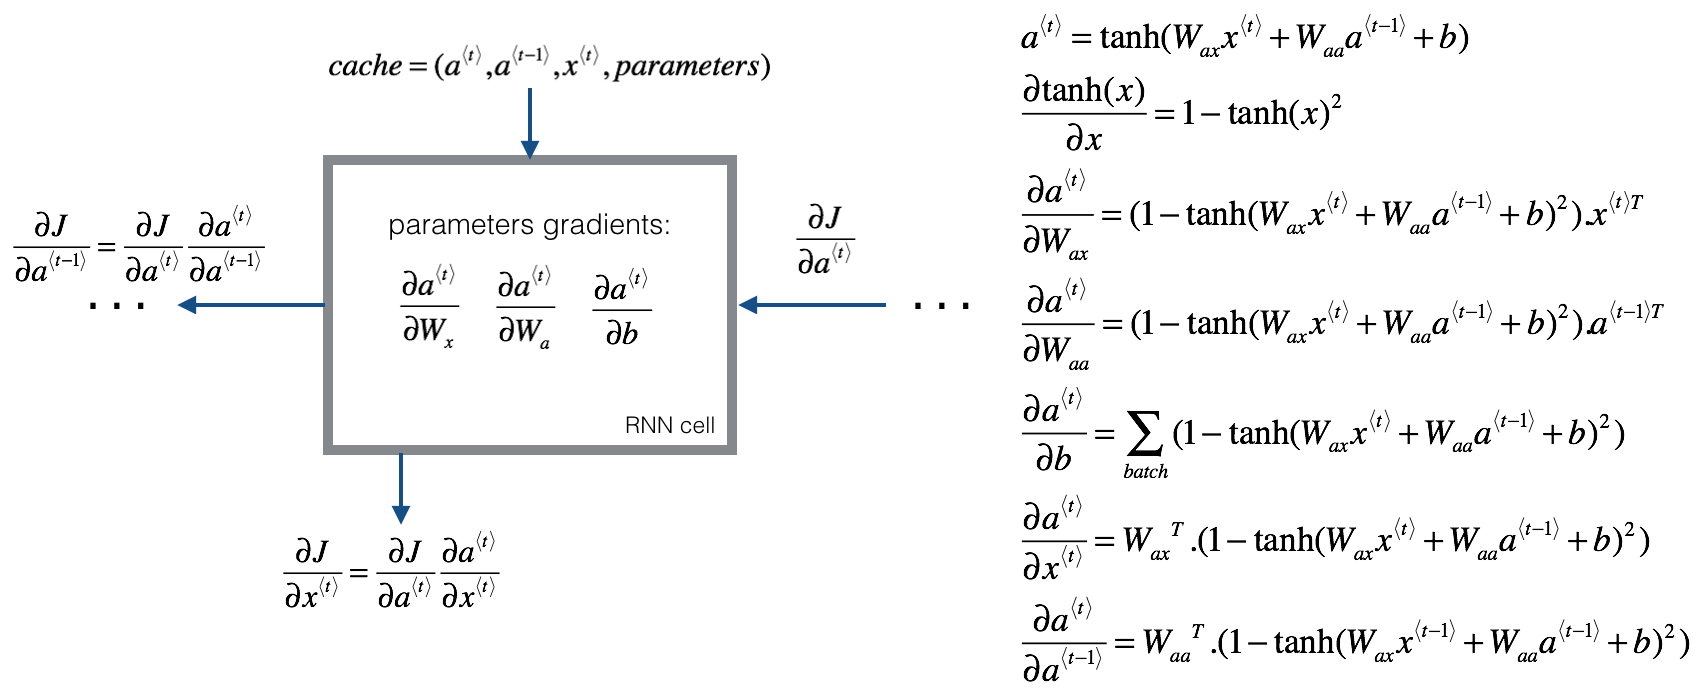

In [17]:
def rnn_cell_backward(da_next,cache) : 
    
    """
    Single pass backward prop on a RNN cell
    
    da_next : the gradient loss wrt to next hidden state
    cache : consisting of values returned by the forward pass

    """
    
    (a_next,a_prev,xt,params) = cache
    
    Wax = params['Wax']
    Waa = params['Waa']
    Wya = params['Wya']
    ba = params['ba']
    by = params['by']
    
    # computing the gradient of tanh wrt a_next
    dtanh = (1-a_next*a_next)*da_next
    
    # computing the gradient of loss wrt Wax
    dxt = np.dot(Wax.T,dtanh)
    dWax = np.dot(dtanh,xt.T)
    
    # computing gradient of loss wrt Waa
    da_prev = np.dot(Waa.T, dtanh)  
    dWaa = np.dot( dtanh,a_prev.T)

    # compute the gradient with respect to b
    dba = np.sum( dtanh,keepdims=True,axis=-1)
     
    # storing grads
    grads = {"dxt": dxt, "da_prev": da_prev, "dWax": dWax, "dWaa": dWaa, "dba": dba}
    
    return grads

#### Backward pass through the RNN


Computing the grads of cost wrt to activation at each timestamp t is important because it is the way for the grads to backpropogate to the previous RNN cell, so we need to iterate through all time stamps from end to start 


In [22]:
def rnn_backward(da,caches) : 
    
    """
    Implementing the backward pass for a RNN over an entire sequence of input data.

    Arguments:
    da -- Upstream gradients of all hidden states, of shape (n_a, m, T_x)
    caches -- tuple containing information from the forward pass (rnn_forward)
    
    """
    
    caches,x = caches
    a1,a0,x1,params = caches[0]
    
    n_a,m,T_x = da.shape
    n_x,m = x1.shape
    
    # initializing the grads
    
    dx = np.zeros((n_x,m,T_x))
    dWax = np.zeros((n_a, n_x))
    dWaa = np.zeros((n_a, n_a))
    dba = np.zeros((n_a, 1)) 
    da0 = np.zeros((n_a, m))
    da_prevt = np.zeros((n_a, m))  
    
    # looping through the timestamps
    
    for t in reversed(range(T_x)) : 
        
        # computing the grads at time step t
        gradients = rnn_cell_backward(da[:,:,t] + da_prevt,caches[t])
        
        # Retrieving stuff 
        dxt, da_prevt, dWaxt, dWaat, dbat = gradients["dxt"], gradients["da_prev"], gradients["dWax"], gradients["dWaa"], gradients["dba"]
        
        # Incrementing the global derivatives wrt params
        dx[:,:,t] = dxt
        dWax += dWaxt
        dWaa += dWaat
        dba += dbat
        
    
    # Set da0 to grad of a which has been propagated through all time steps
    da0 = da_prevt
    
    gradients = {"dx": dx, "da0": da0, "dWax": dWax, "dWaa": dWaa,"dba": dba}
    
    return gradients
    
        

In [24]:
# sample check

np.random.seed(1)
x_tmp = np.random.randn(3,10,4)
a0_tmp = np.random.randn(5,10)
parameters_tmp = {}
parameters_tmp['Wax'] = np.random.randn(5,3)
parameters_tmp['Waa'] = np.random.randn(5,5)
parameters_tmp['Wya'] = np.random.randn(2,5)
parameters_tmp['ba'] = np.random.randn(5,1)
parameters_tmp['by'] = np.random.randn(2,1)

a_tmp, y_tmp, caches_tmp = rnn_forward(x_tmp, a0_tmp, parameters_tmp)
da_tmp = np.random.randn(5, 10, 4)
gradients_tmp = rnn_backward(da_tmp, caches_tmp)

print("gradients[\"dx\"][1][2] =", gradients_tmp["dx"][1][2])
print("gradients[\"dx\"].shape =", gradients_tmp["dx"].shape)
print("gradients[\"da0\"][2][3] =", gradients_tmp["da0"][2][3])
print("gradients[\"da0\"].shape =", gradients_tmp["da0"].shape)
print("gradients[\"dWax\"][3][1] =", gradients_tmp["dWax"][3][1])
print("gradients[\"dWax\"].shape =", gradients_tmp["dWax"].shape)
print("gradients[\"dWaa\"][1][2] =", gradients_tmp["dWaa"][1][2])
print("gradients[\"dWaa\"].shape =", gradients_tmp["dWaa"].shape)
print("gradients[\"dba\"][4] =", gradients_tmp["dba"][4])
print("gradients[\"dba\"].shape =", gradients_tmp["dba"].shape)


gradients["dx"][1][2] = [-2.07101689 -0.59255627  0.02466855  0.01483317]
gradients["dx"].shape = (3, 10, 4)
gradients["da0"][2][3] = -0.31494237512664996
gradients["da0"].shape = (5, 10)
gradients["dWax"][3][1] = 11.264104496527777
gradients["dWax"].shape = (5, 3)
gradients["dWaa"][1][2] = 2.303333126579893
gradients["dWaa"].shape = (5, 5)
gradients["dba"][4] = [-0.74747722]
gradients["dba"].shape = (5, 1)


### LSTM (Long Short Term Memory) network

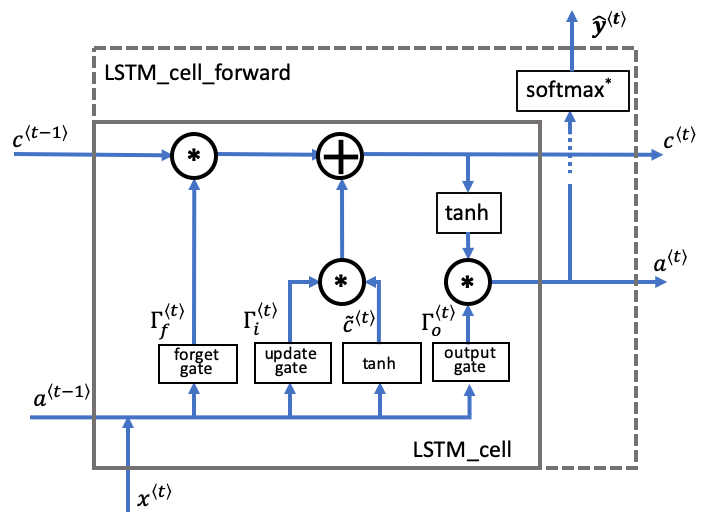

Let's have a review of the gates and equations of them

**Forget gate $\mathbf{\Gamma}_{f}$ :** 

The purpose of forget gate is a gate that decides whether to forget the stored state in corresponding unit of the previous cell state or to keep remmembering it considering it to be important, it's application can be subjeted to the use when we need to keep track whether the upcoming word should be singular or plural depending on the past word formations.

Equation :

$$\mathbf{\Gamma}_f^{\langle t \rangle} = \sigma(\mathbf{W}_f[\mathbf{a}^{\langle t-1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_f)\tag{1} $$


Explanation of the equation :

- $\mathbf{W_{f}}$ contains weights that govern the forget gate's behavior.
- The previous time step's hidden state $[a^{\langle t-1 \rangle}$ and current time step's input $x^{\langle t \rangle}]$ are concatenated together and multiplied by $\mathbf{W_{f}}$.
- A sigmoid function is used to make each of the gate tensor's values $\mathbf{\Gamma}_f^{\langle t \rangle}$ range from 0 to 1.
- The forget gate $\mathbf{\Gamma}_f^{\langle t \rangle}$ has the same dimensions as the previous cell state $c^{\langle t-1 \rangle}$.
- This means that the two can be multiplied together, element-wise.
- Multiplying the tensors $\mathbf{\Gamma}_f^{\langle t \rangle} * \mathbf{c}^{\langle t-1 \rangle}$ is like applying a mask over the previous cell state.
- If a single value in $\mathbf{\Gamma}_f^{\langle t \rangle}$ is 0 or close to 0, then the product is close to 0.
  -     This keeps the information stored in the corresponding unit in $\mathbf{c}^{\langle t-1 \rangle}$ from being remembered for the next time step.
- Similarly, if one value is close to 1, the product is close to the original value in the previous cell state.
  -      The LSTM will keep the information from the corresponding unit of $\mathbf{c}^{\langle t-1 \rangle}$, to be used in the next time step.



**Candidate value $\tilde{\mathbf{c}}^{\langle t \rangle}$:**

  -  The candidate value is a tensor containing information from the current time step that **may** be stored in the current cell state $\mathbf{c}^{\langle t \rangle}$.
  -  Which parts of the candidate value get passed on depends on the update gate.
  -  The candidate value is a tensor containing values that range from -1 to 1.
  -  The tilde "~" is used to differentiate the candidate $\tilde{\mathbf{c}}^{\langle t \rangle}$ from the cell state $\mathbf{c}^{\langle t \rangle}$.

Equation
$$\mathbf{\tilde{c}}^{\langle t \rangle} = \tanh\left( \mathbf{W}_{c} [\mathbf{a}^{\langle t - 1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_{c} \right) \tag{2}$$



**Update gate $\mathbf{\Gamma}_{i}$ :** 

- We use the update gate to decide what aspects of the candidate $\tilde{\mathbf{c}}^{\langle t \rangle}$ to add to cell state $\mathbf{c}^{\langle t \rangle}$.

- The update gate decides what parts of a "candidate" tensor $\tilde{\mathbf{c}}^{\langle t \rangle}$ are passed onto the cell state $\mathbf{c}^{\langle t \rangle}$.
- The update gate is a tensor containing values between 0 and 1.

  -  When a unit in the update gate is close to 1, it allows the value of the candidate $\tilde{\mathbf{c}}^{\langle t \rangle}$ to be passed onto the hidden state $\mathbf{c}^{\langle t \rangle}$
  -  When a unit in the update gate is close to 0, it prevents the corresponding value in the candidate from being passed onto the hidden state.

- Notice that we use the subscript "i" and not "u", to follow the convention used in the literature.

Equation
$$\mathbf{\Gamma}_i^{\langle t \rangle} = \sigma(\mathbf{W}_i[a^{\langle t-1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_i)\tag{3} $$
Explanation of the equation:

- Similar to the forget gate, here $\mathbf{\Gamma}_i^{\langle t \rangle}$, the sigmoid produces values between 0 and 1.
- The update gate is multiplied element-wise with the candidate, and this product ($\mathbf{\Gamma}_{i}^{\langle t \rangle} * \tilde{c}^{\langle t \rangle}$) is used in determining the cell state $\mathbf{c}^{\langle t \rangle}$.



**Cell state $\mathbf{c}^{\langle t \rangle}$:**

 -   The cell state is the "memory" that gets passed onto future time steps.
 -   The new cell state $\mathbf{c}^{\langle t \rangle}$ is a combination of the previous cell state and the candidate value.

Equation
$$ \mathbf{c}^{\langle t \rangle} = \mathbf{\Gamma}_f^{\langle t \rangle}* \mathbf{c}^{\langle t-1 \rangle} + \mathbf{\Gamma}_{i}^{\langle t \rangle} *\mathbf{\tilde{c}}^{\langle t \rangle} \tag{4} $$
Explanation of equation:

  -  The previous cell state $\mathbf{c}^{\langle t-1 \rangle}$ is adjusted (weighted) by the forget gate $\mathbf{\Gamma}_{f}^{\langle t \rangle}$
   - and the candidate value $\tilde{\mathbf{c}}^{\langle t \rangle}$, adjusted (weighted) by the update gate $\mathbf{\Gamma}_{i}^{\langle t \rangle}$


**Output gate $\mathbf{\Gamma}_{o}$:**

   - The output gate decides what gets sent as the prediction (output) of the time step.
   - The output gate is like the other gates. It contains values that range from 0 to 1.

Equation
$$ \mathbf{\Gamma}_o^{\langle t \rangle}= \sigma(\mathbf{W}_o[\mathbf{a}^{\langle t-1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_{o})\tag{5}$$

Explanation of the equation:
   -  The output gate is determined by the previous hidden state $\mathbf{a}^{\langle t-1 \rangle}$ and the current input $\mathbf{x}^{\langle t \rangle}$
   -  The sigmoid makes the gate range from 0 to 1.


**Hidden state $\mathbf{a}^{\langle t \rangle}$:**

 -   The hidden state gets passed to the LSTM cell's next time step.
 -   It is used to determine the three gates ($\mathbf{\Gamma}_{f}, \mathbf{\Gamma}_{u}, \mathbf{\Gamma}_{o}$) of the next time step.
 -   The hidden state is also used for the prediction $y^{\langle t \rangle}$.

Equation
$$ \mathbf{a}^{\langle t \rangle} = \mathbf{\Gamma}_o^{\langle t \rangle} * \tanh(\mathbf{c}^{\langle t \rangle})\tag{6} $$
Explanation of equation:

 - The hidden state $\mathbf{a}^{\langle t \rangle}$ is determined by the cell state $\mathbf{c}^{\langle t \rangle}$ in combination with the output gate $\mathbf{\Gamma}_{o}$.
 -  The cell state state is passed through the "tanh" function to rescale values between -1 and +1.
 -  The output gate acts like a "mask" that either preserves the values of $\tanh(\mathbf{c}^{\langle t \rangle})$ or keeps those values from being included in the hidden state $\mathbf{a}^{\langle t \rangle}$



**Prediction $\mathbf{y}^{\langle t \rangle}_{pred}$:**

  - The prediction in this use case is a classification, so we'll use a softmax.

The equation is: $$\mathbf{y}^{\langle t \rangle}_{pred} = \textrm{softmax}(\mathbf{W}_{y} \mathbf{a}^{\langle t \rangle} + \mathbf{b}_{y})$$

#### Now we will implement the lstm forward propogation for one cell firstly

we will concatenate the hidden state $a^{\langle t-1 \rangle}$ and input $x^{\langle t \rangle}$ and then use formulas from (1) to (6) for gates,hidden state and cell state and finally compute the prediction $y^{\langle t \rangle}$

In [35]:
def lstm_cell_forward(xt,a_prev,c_prev,parameters) :
    
    '''
    xt -- your input data at timestep "t", numpy array of shape (n_x, m).
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    c_prev -- Memory state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        Wi -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        bi -- Bias of the update gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc --  Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        bo --  Bias of the output gate, numpy array of shape (n_a, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
                        
    Returns:
    a_next -- next hidden state, of shape (n_a, m)
    c_next -- next memory state, of shape (n_a, m)
    yt_pred -- prediction at timestep "t", numpy array of shape (n_y, m)
    cache -- tuple of values needed for the backward pass, contains (a_next, c_next, a_prev, c_prev, xt, parameters)
    
    '''
    Wf = parameters["Wf"] # forget gate weight
    bf = parameters["bf"]
    Wi = parameters["Wi"] # update gate weight 
    bi = parameters["bi"]
    Wc = parameters["Wc"] # candidate value weight
    bc = parameters["bc"]
    Wo = parameters["Wo"] # output gate weight
    bo = parameters["bo"]
    Wy = parameters["Wy"] # prediction weight
    by = parameters["by"]
    
    # Retrieving dimensions of xt and Wy
    n_x,m = xt.shape
    n_y,n_a = Wy.shape
    
    # Concatenating the a_prev and xt
    concat =np.zeros([n_x + n_a,m])
    concat[:n_a, :] = a_prev
    concat[n_a :, :] = xt
    
    # computing the gates, cct,c_next,a_next
    ft = sigmoid(np.dot(Wf,concat) + bf)
    it = sigmoid(np.dot(Wi,concat) + bi)
    cct = np.tanh(np.dot(Wc,concat) + bc)
    c_next = ft * c_prev + it * cct
    ot = sigmoid(np.dot(Wo,concat) + bo)
    a_next = ot*np.tanh(c_next)
    
    # computing prediction of LSTM
    yt_pred = softmax(np.dot(Wy,a_next) + by)
    
    cache  = (a_next,c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters)
    
    return a_next,c_next, yt_pred, cache

In [37]:
def lstm_forward(x,a0,parameters):
    
    #initialize "caches", which will track the list of all the caches
    caches = []
    
   
    Wy = parameters['Wy'] # saving parameters['Wy'] in a local variable in case students use Wy instead of parameters['Wy']
    # Retrieve dimensions from shapes of x and parameters['Wy'] 
    n_x, m, T_x = x.shape
    n_y, n_a = Wy.shape
    
    # initialize "a", "c" and "y" with zeros 
    a = np.zeros([n_a, m, T_x])
    c = np.zeros([n_a, m, T_x])
    y = np.zeros([n_y, m, T_x])
    
    # Initialize a_next and c_next
    a_next = a0
    c_next = np.zeros([n_a,m])
    
    # loop over all time-steps
    for t in range(T_x):
        # Update next hidden state, next memory state, compute the prediction, get the cache 
        a_next, c_next, yt, cache = lstm_cell_forward(x[:,:,t], a_next, c_next, parameters)
        # Save the value of the new "next" hidden state in a 
        a[:,:,t] = a_next
        # Save the value of the prediction in y 
        y[:,:,t] = yt
        # Save the value of the next cell state
        c[:,:,t]  = c_next
        # Append the cache into caches 
        caches.append(cache)
        
    
    # store values needed for backward propagation in cache
    caches = (caches, x)

    return a, y, c, caches


### The LSTM Backward Propagation


#### one step backward
The LSTM backward pass is slightly more complicated than the forward one. We have provided you with all the equations for the LSTM backward pass below. (If you enjoy calculus exercises feel free to try deriving these from scratch yourself.)

**gate derivatives**
$$d \Gamma_o^{\langle t \rangle} = da_{next}*\tanh(c_{next}) * \Gamma_o^{\langle t \rangle}*(1-\Gamma_o^{\langle t \rangle})\tag{7}$$$$d\tilde c^{\langle t \rangle} = dc_{next}*\Gamma_u^{\langle t \rangle}+ \Gamma_o^{\langle t \rangle} (1-\tanh(c_{next})^2) * i_t * da_{next} * \tilde c^{\langle t \rangle} * (1-\tanh(\tilde c)^2) \tag{8}$$$$d\Gamma_u^{\langle t \rangle} = dc_{next}*\tilde c^{\langle t \rangle} + \Gamma_o^{\langle t \rangle} (1-\tanh(c_{next})^2) * \tilde c^{\langle t \rangle} * da_{next}*\Gamma_u^{\langle t \rangle}*(1-\Gamma_u^{\langle t \rangle})\tag{9}$$$$d\Gamma_f^{\langle t \rangle} = dc_{next}*\tilde c_{prev} + \Gamma_o^{\langle t \rangle} (1-\tanh(c_{next})^2) * c_{prev} * da_{next}*\Gamma_f^{\langle t \rangle}*(1-\Gamma_f^{\langle t \rangle})\tag{10}$$
**parameter derivatives**
$$ dW_f = d\Gamma_f^{\langle t \rangle} * \begin{pmatrix} a_{prev} \\ x_t\end{pmatrix}^T \tag{11} $$$$ dW_u = d\Gamma_u^{\langle t \rangle} * \begin{pmatrix} a_{prev} \\ x_t\end{pmatrix}^T \tag{12} $$$$ dW_c = d\tilde c^{\langle t \rangle} * \begin{pmatrix} a_{prev} \\ x_t\end{pmatrix}^T \tag{13} $$$$ dW_o = d\Gamma_o^{\langle t \rangle} * \begin{pmatrix} a_{prev} \\ x_t\end{pmatrix}^T \tag{14}$$

To calculate $db_f, db_u, db_c, db_o$ you just need to sum across the horizontal (axis= 1) axis on $d\Gamma_f^{\langle t \rangle}, d\Gamma_u^{\langle t \rangle}, d\tilde c^{\langle t \rangle}, d\Gamma_o^{\langle t \rangle}$ respectively. Note that you should have the keep_dims = True option.

Finally, you will compute the derivative with respect to the previous hidden state, previous memory state, and input.
$$ da_{prev} = W_f^T*d\Gamma_f^{\langle t \rangle} + W_u^T * d\Gamma_u^{\langle t \rangle}+ W_c^T * d\tilde c^{\langle t \rangle} + W_o^T * d\Gamma_o^{\langle t \rangle} \tag{15}$$

Here, the weights for equations 13 are the first n_a, (i.e. $W_f = W_f[:n_a,:]$ etc...)
$$ dc_{prev} = dc_{next}\Gamma_f^{\langle t \rangle} + \Gamma_o^{\langle t \rangle} * (1- \tanh(c_{next})^2)*\Gamma_f^{\langle t \rangle}*da_{next} \tag{16}$$$$ dx^{\langle t \rangle} = W_f^T*d\Gamma_f^{\langle t \rangle} + W_u^T * d\Gamma_u^{\langle t \rangle}+ W_c^T * d\tilde c_t + W_o^T * d\Gamma_o^{\langle t \rangle}\tag{17} $$

where the weights for equation 15 are from n_a to the end, (i.e. $W_f = W_f[n_a:,:]$ etc...)


In [41]:
def lstm_cell_backward(da_next,dc_next,cache) : 
    '''
     we will implement lstm_cell_backward by implementing equations 7 - 17 shown above.
    '''

    
    # Retrieve information from "cache"
    (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters) = cache
    
    # Retrieve dimensions from xt's and a_next's shape 
    n_x, m = xt.shape 
    n_a, m = a_next.shape 
    
    # Compute gates related derivatives, you can find their values can be found by looking carefully at equations (7) to (10)
    # Code equations (7) to (10) (≈4 lines)
    dit = (da_next * ot * (1 - np.tanh(c_next) ** 2) + dc_next) * cct * (1 - it) * it
    dft = (da_next * ot * (1 - np.tanh(c_next) ** 2) + dc_next) * c_prev * ft * (1 - ft)
    dot = da_next * np.tanh(c_next) * ot * (1 - ot)
    dcct = (da_next * ot * (1 - np.tanh(c_next) ** 2) + dc_next) * it * (1 - cct ** 2)

    # Compute parameters related derivatives. Use equations (11)-(14) 
    dWf = np.dot(dft,np.concatenate((a_prev, xt), axis=0).T) # or use np.dot(dft, np.hstack([a_prev.T, xt.T]))
    dWi = np.dot(dit,np.concatenate((a_prev, xt), axis=0).T)
    dWc = np.dot(dcct,np.concatenate((a_prev, xt), axis=0).T)
    dWo = np.dot(dot,np.concatenate((a_prev, xt), axis=0).T)
    dbf = np.sum(dft,axis=1,keepdims=True)
    dbi = np.sum(dit,axis=1,keepdims=True) 
    dbc = np.sum(dcct,axis=1,keepdims=True) 
    dbo = np.sum(dot,axis=1,keepdims=True)  

    # Compute derivatives w.r.t previous hidden state, previous memory state and input. Use equations (15)-(17).
    da_prev = np.dot(parameters['Wf'][:,:n_a].T,dft)+np.dot(parameters['Wi'][:,:n_a].T,dit)+np.dot(parameters['Wc'][:,:n_a].T,dcct)+np.dot(parameters['Wo'][:,:n_a].T,dot) 
    dc_prev = dc_next*ft+ot*(1-np.square(np.tanh(c_next)))*ft*da_next 
    dxt = np.dot(parameters['Wf'][:,n_a:].T,dft)+np.dot(parameters['Wi'][:,n_a:].T,dit)+np.dot(parameters['Wc'][:,n_a:].T,dcct)+np.dot(parameters['Wo'][:,n_a:].T,dot) 
    
    # Save gradients in dictionary
    gradients = {"dxt": dxt, "da_prev": da_prev, "dc_prev": dc_prev, "dWf": dWf,"dbf": dbf, "dWi": dWi,"dbi": dbi,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}

    return gradients


### Backward LSTM full

This part is very similar to the rnn_backward function you implemented above. We will first create variables of the same dimension as your return variables. We will then iterate over all the time steps starting from the end and call the one step function you implemented for LSTM at each iteration. We will then update the parameters by summing them individually. Finally return a dictionary with the new gradients.

In [43]:
def lstm_backward(da, caches):
    
    """
    Implement the backward pass for the RNN with LSTM-cell (over a whole sequence).

    Arguments:
    da -- Gradients w.r.t the hidden states, numpy-array of shape (n_a, m, T_x)
    caches -- cache storing information from the forward pass (lstm_forward)

    """

    # Retrieve values from the first cache (t=1) of caches.
    (caches, x) = caches
    (a1, c1, a0, c0, f1, i1, cc1, o1, x1, parameters) = caches[0]
    
    # Retrieve dimensions from da's and x1's shapes 
    n_a, m, T_x = da.shape
    n_x, m = x1.shape
    
    # initialize the gradients with the right sizes 
    dx = np.zeros((n_x, m, T_x))
    da0 = np.zeros((n_a, m))
    da_prevt = np.zeros((n_a, m))
    dc_prevt = np.zeros((n_a, m))
    dWf = np.zeros((n_a, n_a + n_x))
    dWi = np.zeros((n_a, n_a + n_x))
    dWc = np.zeros((n_a, n_a + n_x))
    dWo = np.zeros((n_a, n_a + n_x))
    dbf = np.zeros((n_a, 1))
    dbi = np.zeros((n_a, 1))
    dbc = np.zeros((n_a, 1))
    dbo = np.zeros((n_a, 1))
    
    # loop back over the whole sequence
    for t in reversed(range(T_x)):
        # Compute all gradients using lstm_cell_backward
        gradients = lstm_cell_backward(da[:,:,t] + da_prevt, dc_prevt, caches[t])
        # Store or add the gradient to the parameters' previous step's gradient
        dx[:,:,t] = gradients["dxt"]
        dWf += gradients["dWf"]
        dWi += gradients["dWi"]
        dWc += gradients["dWc"]
        dWo += gradients["dWo"]
        dbf += gradients["dbf"]
        dbi += gradients["dbi"]
        dbc += gradients["dbc"]
        dbo += gradients["dbo"]
    # Set the first activation's gradient to the backpropagated gradient da_prev.
    da0 = gradients["da_prev"]
    

    # Store the gradients in a python dictionary
    gradients = {"dx": dx, "da0": da0, "dWf": dWf,"dbf": dbf, "dWi": dWi,"dbi": dbi,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}
    
    return gradients

In [45]:
# sample test


np.random.seed(1)
x_tmp = np.random.randn(3,10,7)
a0_tmp = np.random.randn(5,10)

parameters_tmp = {}
parameters_tmp['Wf'] = np.random.randn(5, 5+3)
parameters_tmp['bf'] = np.random.randn(5,1)
parameters_tmp['Wi'] = np.random.randn(5, 5+3)
parameters_tmp['bi'] = np.random.randn(5,1)
parameters_tmp['Wo'] = np.random.randn(5, 5+3)
parameters_tmp['bo'] = np.random.randn(5,1)
parameters_tmp['Wc'] = np.random.randn(5, 5+3)
parameters_tmp['bc'] = np.random.randn(5,1)
parameters_tmp['Wy'] = np.random.randn(2,5)
parameters_tmp['by'] = np.random.randn(2,1)

a_tmp, y_tmp, c_tmp, caches_tmp = lstm_forward(x_tmp, a0_tmp, parameters_tmp)

da_tmp = np.random.randn(5, 10, 4)
gradients_tmp = lstm_backward(da_tmp, caches_tmp)

print("gradients[\"dx\"][1][2] =", gradients_tmp["dx"][1][2])
print("gradients[\"dx\"].shape =", gradients_tmp["dx"].shape)
print("gradients[\"da0\"][2][3] =", gradients_tmp["da0"][2][3])
print("gradients[\"da0\"].shape =", gradients_tmp["da0"].shape)
print("gradients[\"dWf\"][3][1] =", gradients_tmp["dWf"][3][1])
print("gradients[\"dWf\"].shape =", gradients_tmp["dWf"].shape)
print("gradients[\"dWi\"][1][2] =", gradients_tmp["dWi"][1][2])
print("gradients[\"dWi\"].shape =", gradients_tmp["dWi"].shape)
print("gradients[\"dWc\"][3][1] =", gradients_tmp["dWc"][3][1])
print("gradients[\"dWc\"].shape =", gradients_tmp["dWc"].shape)
print("gradients[\"dWo\"][1][2] =", gradients_tmp["dWo"][1][2])
print("gradients[\"dWo\"].shape =", gradients_tmp["dWo"].shape)
print("gradients[\"dbf\"][4] =", gradients_tmp["dbf"][4])
print("gradients[\"dbf\"].shape =", gradients_tmp["dbf"].shape)
print("gradients[\"dbi\"][4] =", gradients_tmp["dbi"][4])
print("gradients[\"dbi\"].shape =", gradients_tmp["dbi"].shape)
print("gradients[\"dbc\"][4] =", gradients_tmp["dbc"][4])
print("gradients[\"dbc\"].shape =", gradients_tmp["dbc"].shape)
print("gradients[\"dbo\"][4] =", gradients_tmp["dbo"][4])
print("gradients[\"dbo\"].shape =", gradients_tmp["dbo"].shape)



gradients["dx"][1][2] = [ 0.01980463 -0.02745056 -0.31327706  0.53886581]
gradients["dx"].shape = (3, 10, 4)
gradients["da0"][2][3] = -0.0002844952897491648
gradients["da0"].shape = (5, 10)
gradients["dWf"][3][1] = -0.01538900433272581
gradients["dWf"].shape = (5, 8)
gradients["dWi"][1][2] = -0.10924217935041784
gradients["dWi"].shape = (5, 8)
gradients["dWc"][3][1] = 0.07939058449325513
gradients["dWc"].shape = (5, 8)
gradients["dWo"][1][2] = -0.08101445436214821
gradients["dWo"].shape = (5, 8)
gradients["dbf"][4] = [-0.24148921]
gradients["dbf"].shape = (5, 1)
gradients["dbi"][4] = [-0.08824333]
gradients["dbi"].shape = (5, 1)
gradients["dbc"][4] = [0.14411048]
gradients["dbc"].shape = (5, 1)
gradients["dbo"][4] = [-0.45977321]
gradients["dbo"].shape = (5, 1)
